In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
from sklearn.model_selection import StratifiedGroupKFold
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))

Numerical features: 281
Categorical features: 6


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0


Numerical Columns: 281
Categorical Columns: 6


/Users/59008/Repositories/kg/mcts-strength-variants/train/../src/preproc.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train["utility_agent1_rank"] = (


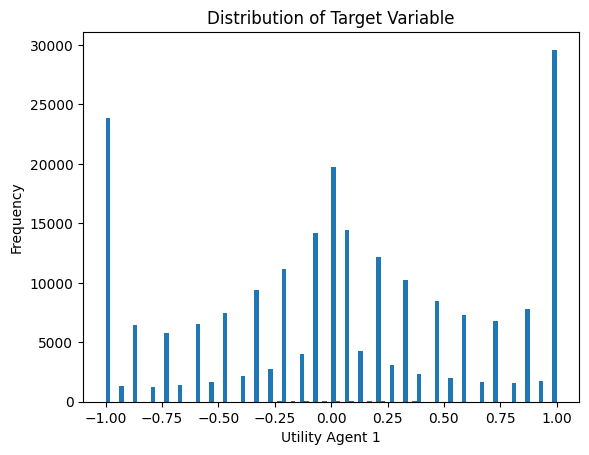

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model


/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1


[50]	valid_0's rmse: 0.483273


[100]	valid_0's rmse: 0.467958


[150]	valid_0's rmse: 0.462489


[200]	valid_0's rmse: 0.457763


[250]	valid_0's rmse: 0.455079


[300]	valid_0's rmse: 0.453305


[350]	valid_0's rmse: 0.451511


[400]	valid_0's rmse: 0.450591


[450]	valid_0's rmse: 0.44948


[500]	valid_0's rmse: 0.448783


[550]	valid_0's rmse: 0.448262


[600]	valid_0's rmse: 0.447816


[650]	valid_0's rmse: 0.447494


[700]	valid_0's rmse: 0.447109


[750]	valid_0's rmse: 0.446954


[800]	valid_0's rmse: 0.446393


[850]	valid_0's rmse: 0.445866


[900]	valid_0's rmse: 0.445587


[950]	valid_0's rmse: 0.445133


[1000]	valid_0's rmse: 0.445151


[1050]	valid_0's rmse: 0.444871


[1100]	valid_0's rmse: 0.444601


[1150]	valid_0's rmse: 0.444511


[1200]	valid_0's rmse: 0.444477


[1250]	valid_0's rmse: 0.444384


[1300]	valid_0's rmse: 0.444237


[1350]	valid_0's rmse: 0.444139


[1400]	valid_0's rmse: 0.444183


[1450]	valid_0's rmse: 0.444241


[1500]	valid_0's rmse: 0.444208


[1550]	valid_0's rmse: 0.44431


[1600]	valid_0's rmse: 0.444137


[1650]	valid_0's rmse: 0.444145


[1700]	valid_0's rmse: 0.444253


[1750]	valid_0's rmse: 0.444296


[1800]	valid_0's rmse: 0.444179


[1850]	valid_0's rmse: 0.444209


[1900]	valid_0's rmse: 0.444186


[1950]	valid_0's rmse: 0.444044


[2000]	valid_0's rmse: 0.443968


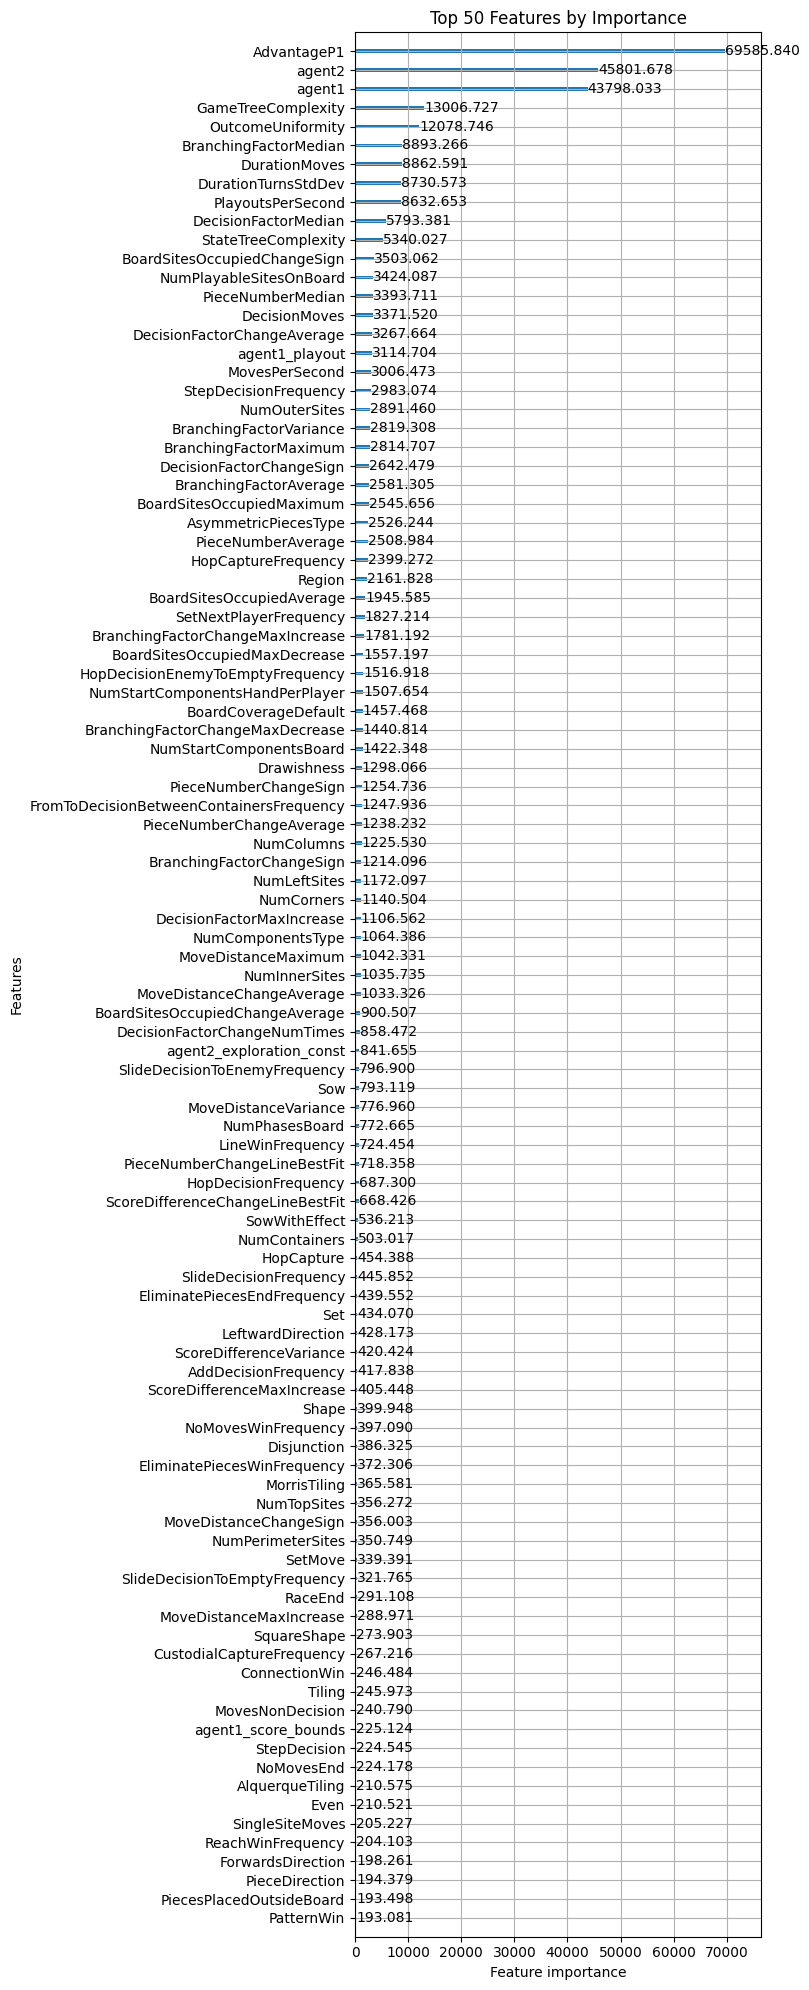

Fold 1 - RMSE: 0.4431110909021611
Fold 2


[50]	valid_0's rmse: 0.494248


[100]	valid_0's rmse: 0.475438


[150]	valid_0's rmse: 0.467548


[200]	valid_0's rmse: 0.464412


[250]	valid_0's rmse: 0.462431


[300]	valid_0's rmse: 0.460316


[350]	valid_0's rmse: 0.458523


[400]	valid_0's rmse: 0.456934


[450]	valid_0's rmse: 0.456376


[500]	valid_0's rmse: 0.455532


[550]	valid_0's rmse: 0.455382


[600]	valid_0's rmse: 0.455268


[650]	valid_0's rmse: 0.454614


[700]	valid_0's rmse: 0.454274


[750]	valid_0's rmse: 0.453622


[800]	valid_0's rmse: 0.45317


[850]	valid_0's rmse: 0.453151


[900]	valid_0's rmse: 0.453248


[950]	valid_0's rmse: 0.453151


[1000]	valid_0's rmse: 0.453041


[1050]	valid_0's rmse: 0.453056


[1100]	valid_0's rmse: 0.452933


[1150]	valid_0's rmse: 0.45256


[1200]	valid_0's rmse: 0.452602


[1250]	valid_0's rmse: 0.452436


[1300]	valid_0's rmse: 0.452204


[1350]	valid_0's rmse: 0.452327


[1400]	valid_0's rmse: 0.452361


[1450]	valid_0's rmse: 0.452105


[1500]	valid_0's rmse: 0.45205


[1550]	valid_0's rmse: 0.452022


[1600]	valid_0's rmse: 0.451824


[1650]	valid_0's rmse: 0.451773


[1700]	valid_0's rmse: 0.451704


[1750]	valid_0's rmse: 0.451698


[1800]	valid_0's rmse: 0.451767


[1850]	valid_0's rmse: 0.451842


[1900]	valid_0's rmse: 0.451737


[1950]	valid_0's rmse: 0.451773


[2000]	valid_0's rmse: 0.451872


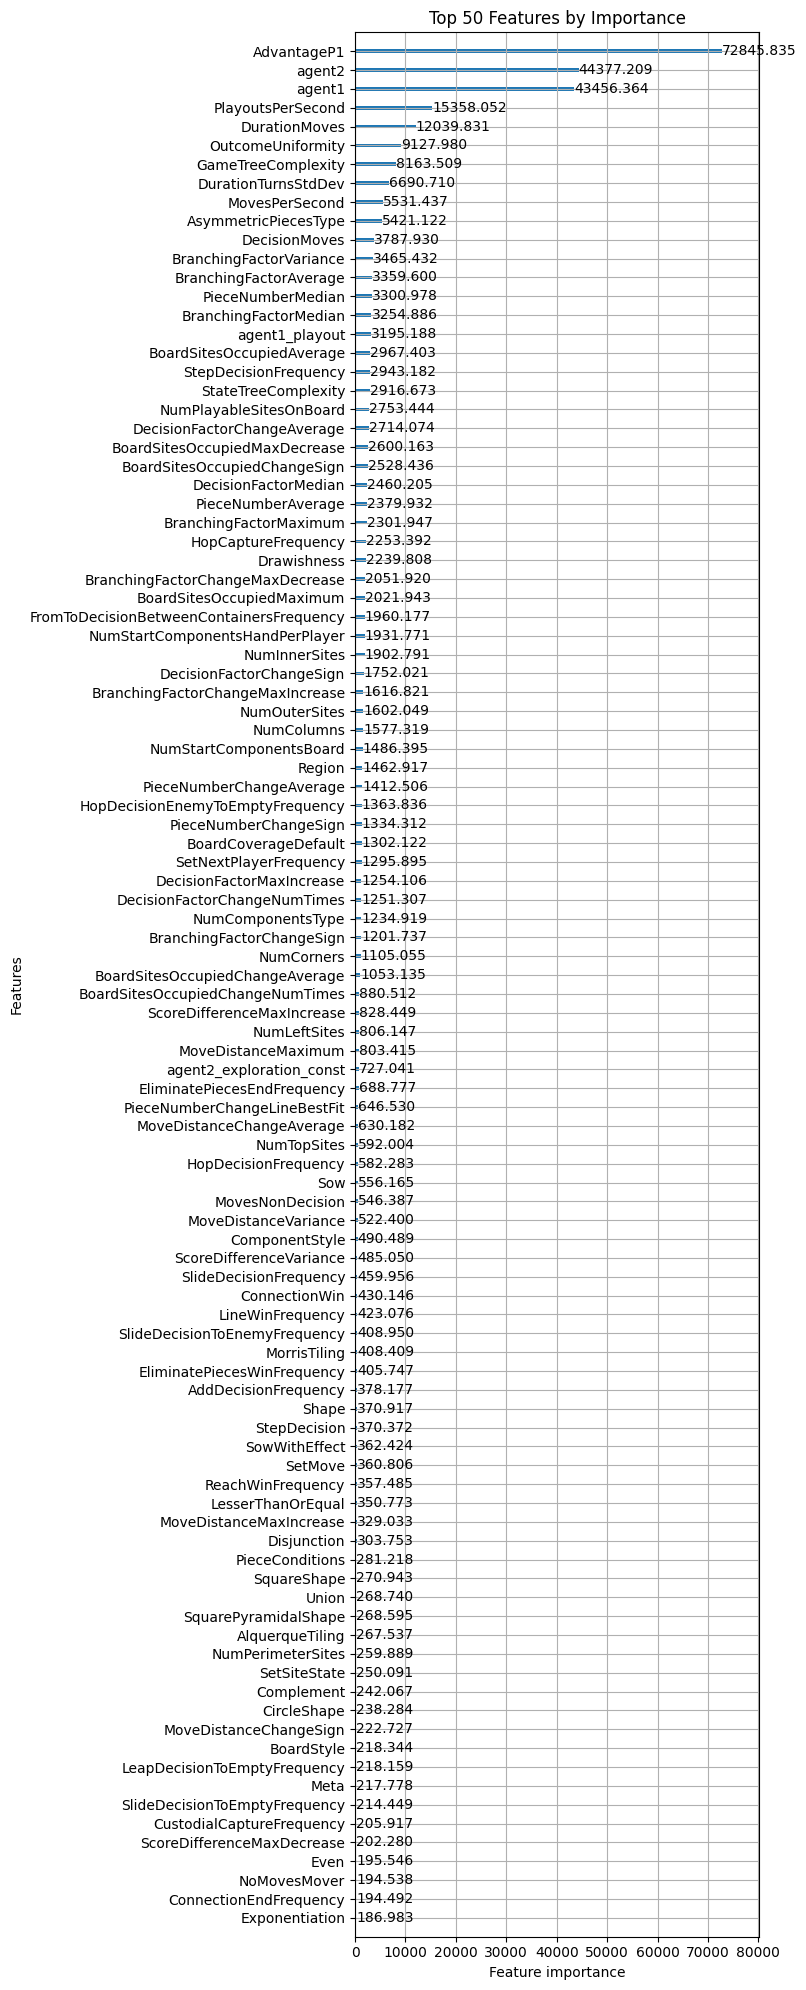

Fold 2 - RMSE: 0.45017462889147425
Fold 3


[50]	valid_0's rmse: 0.451172


[100]	valid_0's rmse: 0.43905


[150]	valid_0's rmse: 0.432596


[200]	valid_0's rmse: 0.42775


[250]	valid_0's rmse: 0.42502


[300]	valid_0's rmse: 0.424059


[350]	valid_0's rmse: 0.422251


[400]	valid_0's rmse: 0.421012


[450]	valid_0's rmse: 0.420147


[500]	valid_0's rmse: 0.419455


[550]	valid_0's rmse: 0.41882


[600]	valid_0's rmse: 0.418627


[650]	valid_0's rmse: 0.418514


[700]	valid_0's rmse: 0.418121


[750]	valid_0's rmse: 0.417818


[800]	valid_0's rmse: 0.417498


[850]	valid_0's rmse: 0.416946


[900]	valid_0's rmse: 0.417076


[950]	valid_0's rmse: 0.416769


[1000]	valid_0's rmse: 0.416755


[1050]	valid_0's rmse: 0.416499


[1100]	valid_0's rmse: 0.416621


[1150]	valid_0's rmse: 0.416283


[1200]	valid_0's rmse: 0.416271


[1250]	valid_0's rmse: 0.416243


[1300]	valid_0's rmse: 0.416252


[1350]	valid_0's rmse: 0.416298


[1400]	valid_0's rmse: 0.41647


[1450]	valid_0's rmse: 0.416498


[1500]	valid_0's rmse: 0.416412


[1550]	valid_0's rmse: 0.416334


[1600]	valid_0's rmse: 0.416298


[1650]	valid_0's rmse: 0.416174


[1700]	valid_0's rmse: 0.416234


[1750]	valid_0's rmse: 0.41628


[1800]	valid_0's rmse: 0.416292


[1850]	valid_0's rmse: 0.416288


[1900]	valid_0's rmse: 0.416324


[1950]	valid_0's rmse: 0.416266


[2000]	valid_0's rmse: 0.416353


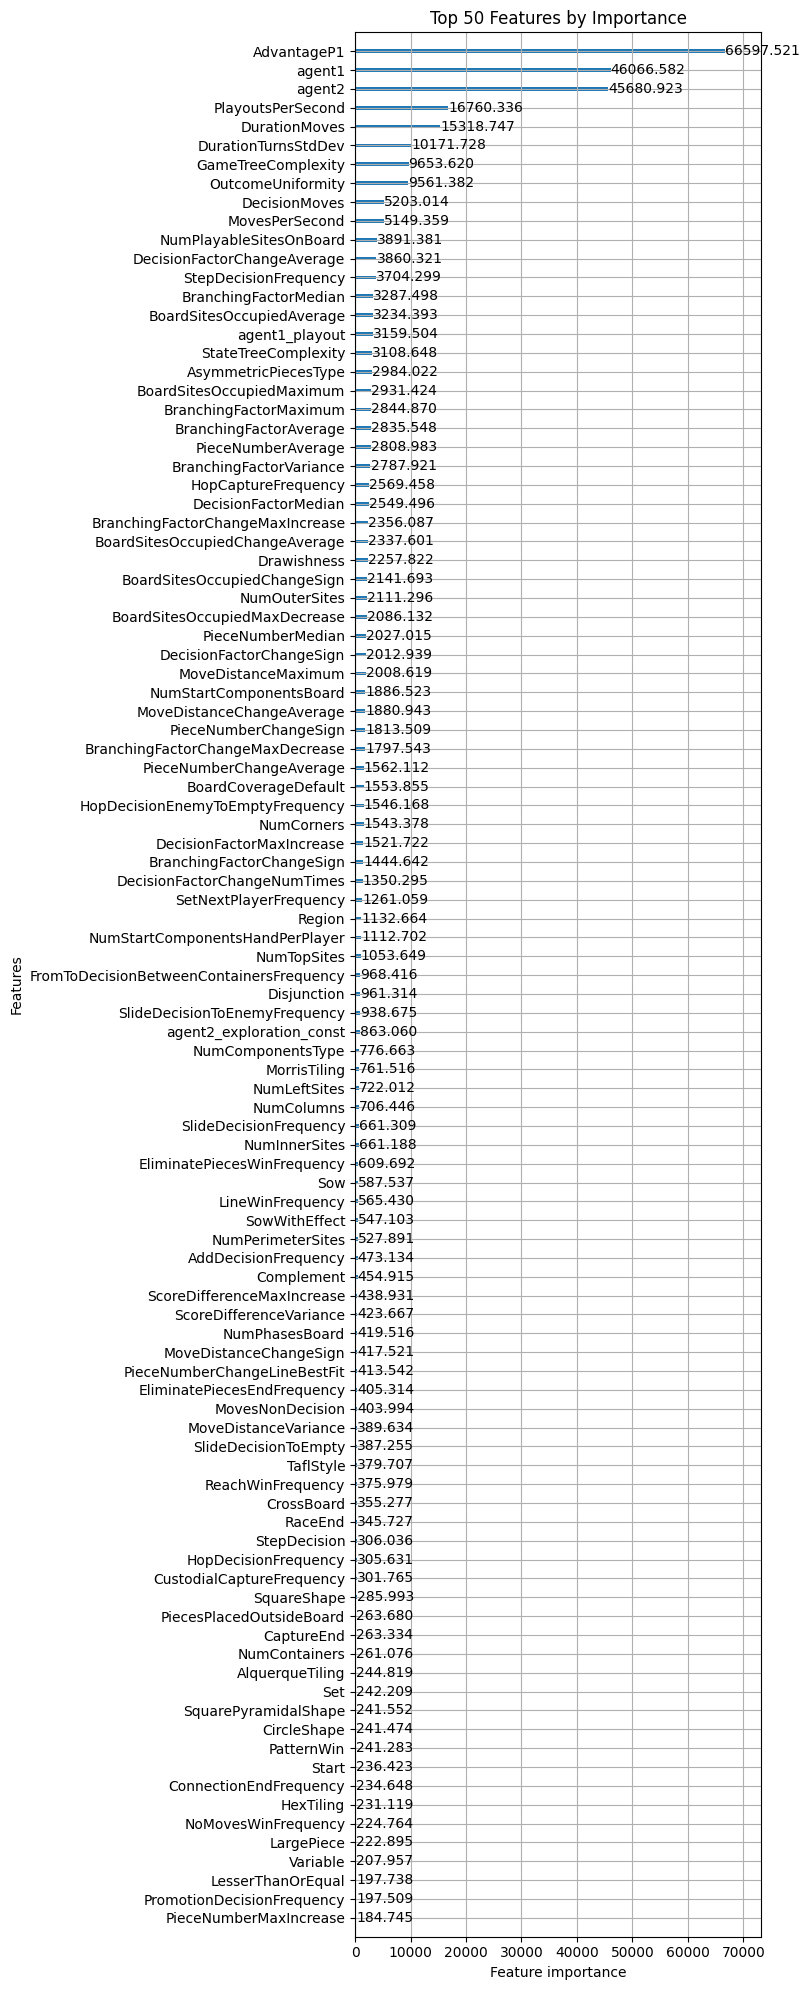

Fold 3 - RMSE: 0.4151890001833824
Fold 4


[50]	valid_0's rmse: 0.485886


[100]	valid_0's rmse: 0.468672


[150]	valid_0's rmse: 0.462508


[200]	valid_0's rmse: 0.457986


[250]	valid_0's rmse: 0.455754


[300]	valid_0's rmse: 0.454495


[350]	valid_0's rmse: 0.453454


[400]	valid_0's rmse: 0.452621


[450]	valid_0's rmse: 0.451657


[500]	valid_0's rmse: 0.450617


[550]	valid_0's rmse: 0.449723


[600]	valid_0's rmse: 0.448667


[650]	valid_0's rmse: 0.447877


[700]	valid_0's rmse: 0.447506


[750]	valid_0's rmse: 0.447164


[800]	valid_0's rmse: 0.446587


[850]	valid_0's rmse: 0.446378


[900]	valid_0's rmse: 0.445673


[950]	valid_0's rmse: 0.445483


[1000]	valid_0's rmse: 0.445321


[1050]	valid_0's rmse: 0.445069


[1100]	valid_0's rmse: 0.444757


[1150]	valid_0's rmse: 0.44458


[1200]	valid_0's rmse: 0.444456


[1250]	valid_0's rmse: 0.44437


[1300]	valid_0's rmse: 0.44435


[1350]	valid_0's rmse: 0.444111


[1400]	valid_0's rmse: 0.443963


[1450]	valid_0's rmse: 0.443958


[1500]	valid_0's rmse: 0.443894


[1550]	valid_0's rmse: 0.443875


[1600]	valid_0's rmse: 0.443838


[1650]	valid_0's rmse: 0.443835


[1700]	valid_0's rmse: 0.443746


[1750]	valid_0's rmse: 0.443678


[1800]	valid_0's rmse: 0.443616


[1850]	valid_0's rmse: 0.44369


[1900]	valid_0's rmse: 0.443626


[1950]	valid_0's rmse: 0.443517


[2000]	valid_0's rmse: 0.443378


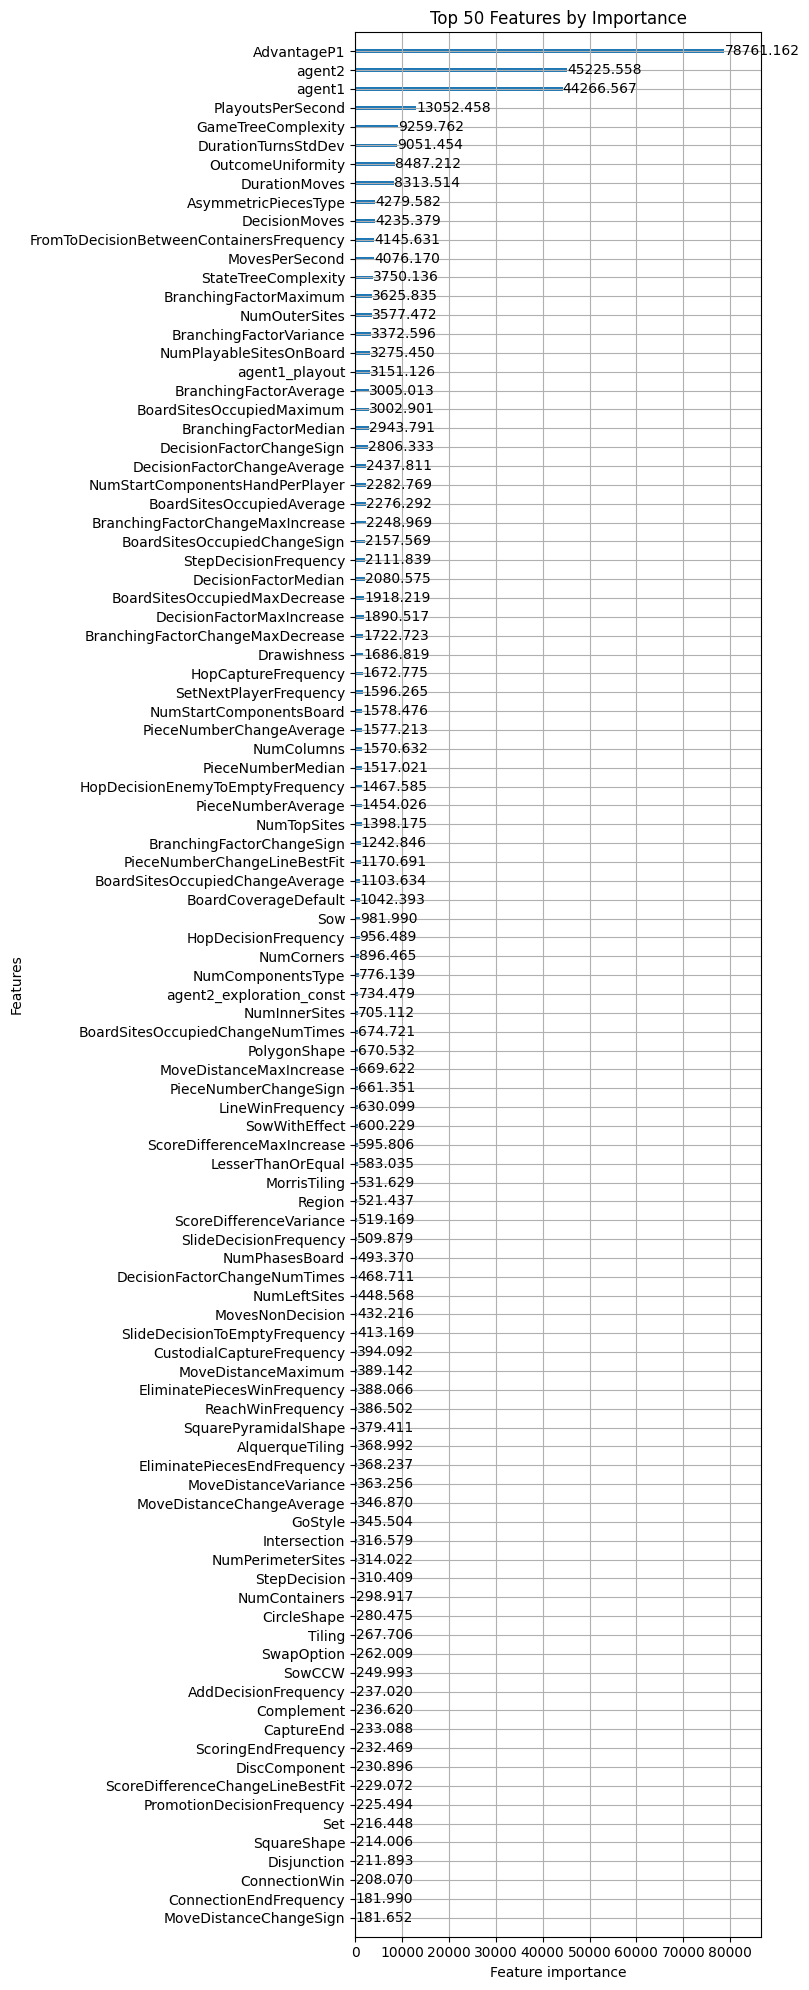

Fold 4 - RMSE: 0.4419765135990646
Fold 5


[50]	valid_0's rmse: 0.474959


[100]	valid_0's rmse: 0.46036


[150]	valid_0's rmse: 0.453938


[200]	valid_0's rmse: 0.451351


[250]	valid_0's rmse: 0.448528


[300]	valid_0's rmse: 0.446743


[350]	valid_0's rmse: 0.445301


[400]	valid_0's rmse: 0.443702


[450]	valid_0's rmse: 0.442057


[500]	valid_0's rmse: 0.441545


[550]	valid_0's rmse: 0.441108


[600]	valid_0's rmse: 0.440535


[650]	valid_0's rmse: 0.440356


[700]	valid_0's rmse: 0.440084


[750]	valid_0's rmse: 0.439754


[800]	valid_0's rmse: 0.439643


[850]	valid_0's rmse: 0.439358


[900]	valid_0's rmse: 0.438995


[950]	valid_0's rmse: 0.438558


[1000]	valid_0's rmse: 0.438537


[1050]	valid_0's rmse: 0.438428


[1100]	valid_0's rmse: 0.438276


[1150]	valid_0's rmse: 0.43817


[1200]	valid_0's rmse: 0.437961


[1250]	valid_0's rmse: 0.437784


[1300]	valid_0's rmse: 0.437572


[1350]	valid_0's rmse: 0.437488


[1400]	valid_0's rmse: 0.437358


[1450]	valid_0's rmse: 0.437345


[1500]	valid_0's rmse: 0.437288


[1550]	valid_0's rmse: 0.437237


[1600]	valid_0's rmse: 0.437187


[1650]	valid_0's rmse: 0.437151


[1700]	valid_0's rmse: 0.437078


[1750]	valid_0's rmse: 0.43697


[1800]	valid_0's rmse: 0.437062


[1850]	valid_0's rmse: 0.436984


[1900]	valid_0's rmse: 0.437077


[1950]	valid_0's rmse: 0.436899


[2000]	valid_0's rmse: 0.436875


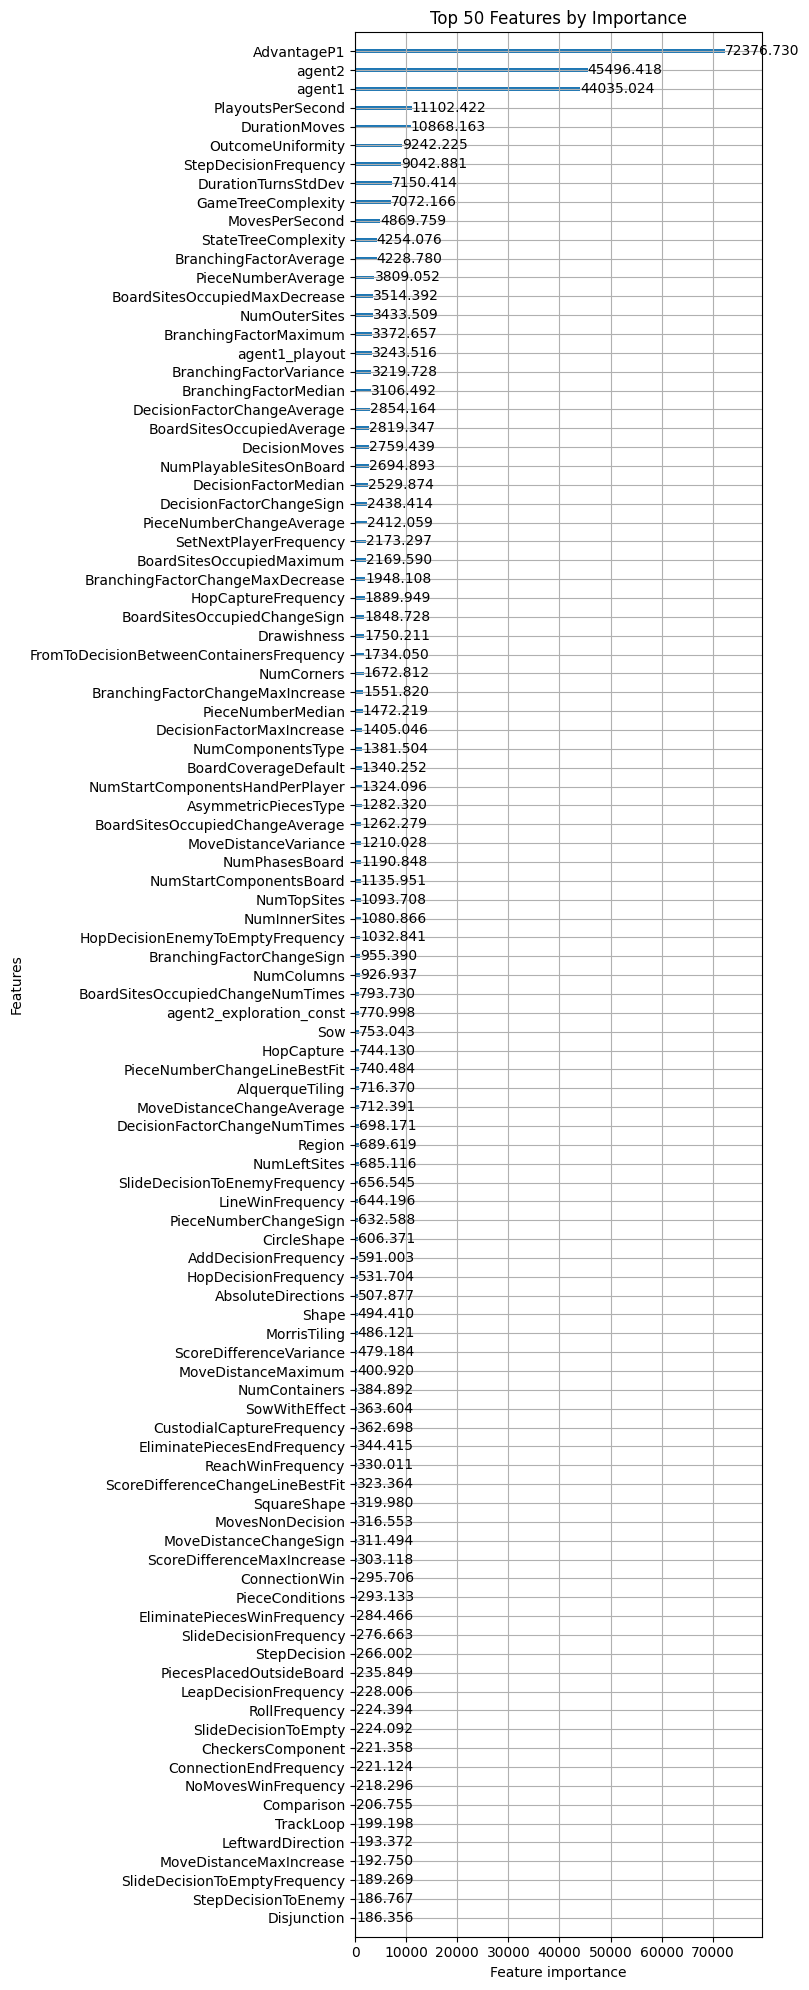

Fold 5 - RMSE: 0.43614936227386936
List of oof scores: [0.4431110909021611, 0.45017462889147425, 0.4151890001833824, 0.4419765135990646, 0.43614936227386936]
Average oof score: 0.4373201191699903


In [6]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        num_folds=5,
    ):
    # Define the number of folds for cross-validation
    group_col = "GameRulesetName"
    y_col = "utility_agent1_rank"
    gkf = StratifiedGroupKFold(n_splits=num_folds, random_state=2112, shuffle=True)
    split_list = gkf.split(df_train, groups=df_train[group_col], y=df_train[y_col])

    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'max_depth': 10,
        'learning_rate': 0.1,
        'reg_alpha': 1e-1,
        'reg_lambda': 1e-1,
        'feature_fraction': 0.8,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(index=df_train.index, columns=[f'{target}_true', f'{target}_pred'])
    oof_scores = []
    feature_importances = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=2000,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=50),
            ]
        )
        lgb.plot_importance(model, figsize=(8, 20), importance_type='gain', max_num_features=100)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])
        y_pred = np.clip(y_pred, -1, 1)
        
        # Compute RMSE on scaled values
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    # save oof predictions
    oof.to_csv(path_results / 'oof_lightgbm.csv', index=False)
    
    return trained_models, oof, oof_scores

# Train the models
trained_models, oof, oof_scores = train_models(df_train, numerical_cols, categorical_cols)

# save oof predictions
oof.to_csv(path_results / 'oof_lightgbm.csv', index=False)

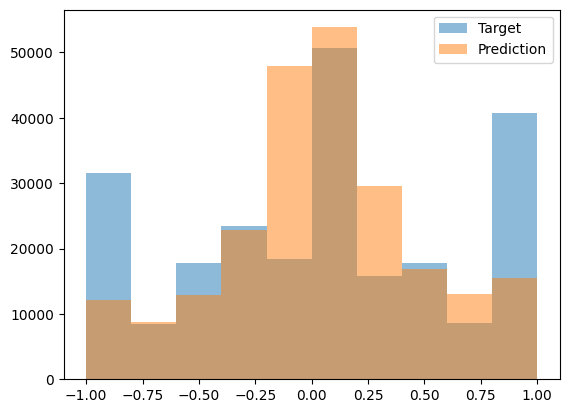

In [7]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [8]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [9]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [10]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

Id,utility_agent1
i64,f64
233234,0.158632
233235,-0.20838
233236,-0.01301


In [11]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [12]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open('./lightgbm_predict.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***